In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import time
from GFire_utils.AllFunctions import *

pd.set_option('display.max_columns', None)

In [2]:
# Hyperparameters
vegetation = [5] # Classes corresponding to vegetation
columns = ['x','y','z', 'class']
outliers = [135]

xinc = 20 # Meters increment of each point of the groundtruth
yinc = 20

threshold_list = [10] #np.arange(0, 20, 1) # Meters from which we start considering that a vegetation is part of the cover

In [3]:
# File reading
my_block = pd.read_csv('../toy dataset/input_toydataset.txt', sep=' ', header = None, names = columns)
groundtruth = pd.read_csv('../toy dataset/groundtruth_toydataset.csv', sep=' ', header = None, names = ['x','y','CC'])

In [19]:
# Heights reading
metadata = pd.read_csv('../toy dataset/met2v10as0f279122mr1r010.txt', sep=' ',skipinitialspace=True, header = None,
                       skip_blank_lines=True, nrows=6)

NCOLS, NROWS, XCENT, YCENT, CELLSIZE, NODATA_VALUE = map(int, metadata.iloc[:][1])
heights = pd.read_csv('../toy dataset/met2v10as0f279122mr1r010.txt', sep=' ', header = None, skip_blank_lines=True, skiprows=6)

heights = fix_format(heights, NCOLS)
heights = index_matrix(heights, XCENT, YCENT, CELLSIZE)
heights.columns = ['x_point', 'y_point', 'real_z']

r2 Accuracy:  0.9400726687821539


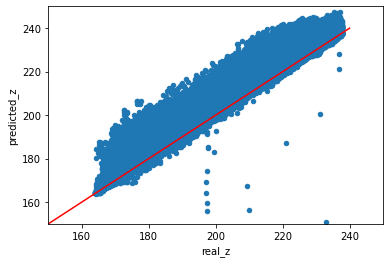

In [5]:
# Check how good our method predicts a block's height
grouping_size = 2 # Side of the square where we consider that the height is constant in meters

my_block['x'] = my_block['x'].map(int)
my_block['y'] = my_block['y'].map(int)

my_block_2 = my_block.copy()
heights_2 = heights.copy()

# Grouping pixels by 2x2m points
my_block_2['x_point'] = ( my_block_2['x']// grouping_size )*grouping_size
my_block_2['y_point'] = ( my_block_2['y']// grouping_size )*grouping_size

heights_2['x_point'] = ( heights_2['x_point']// grouping_size )*grouping_size
heights_2['y_point'] = ( heights_2['y_point']// grouping_size )*grouping_size

my_block_2 = my_block_2.groupby(['x_point','y_point'])[['z']].min().reset_index()
heights_2 = heights_2.groupby(['x_point','y_point'])[['real_z']].min().reset_index()

my_block_2.columns = ['x_point','y_point', 'predicted_z']

new_df = pd.merge(my_block_2, heights_2, on=['x_point','y_point'], how='left')

acc = r2_score(new_df['real_z'], new_df['predicted_z'])

print("r2 Accuracy: ", acc)

new_df.plot.scatter(x='real_z', y = 'predicted_z')
plt.xlim(150,250)
plt.ylim(150,250)
plt.plot([0,240], [0, 240], c='red')
plt.show()

In [67]:
th_list = np.arange(1, 20, 1)
my_acc = []

for threshold in th_list:
    # File reading
    my_block = pd.read_csv('../toy dataset/input_toydataset.txt', sep=' ', header = None, names = columns)
    groundtruth = pd.read_csv('../toy dataset/groundtruth_toydataset.csv', sep=' ', header = None, names = ['x_point','y_point','CC'])

    grouping_size = 2 # Side of the square where we consider that the height is constant in meters
    my_block['x_point'] = ( my_block['x']// grouping_size )*grouping_size
    my_block['y_point'] = ( my_block['y']// grouping_size )*grouping_size

    heights['x_point'] = ( heights['x_point']// grouping_size )*grouping_size
    heights['y_point'] = ( heights['y_point']// grouping_size )*grouping_size

    my_block = pd.merge(my_block, heights, on=['x_point','y_point'], how='left')

    my_block['height'] = my_block['z'] - my_block['real_z']


    # Grouping now for each point as the GT has 20x20m size
    grouping_size = 20

    my_block['x_point'] = ( my_block['x']// grouping_size )*grouping_size + 10*(2*(my_block['x'] % 20 > 10)-1)
    my_block['y_point'] = ( my_block['y']// grouping_size )*grouping_size + 10*(2*(my_block['y'] % 20 > 10)-1)
    
#     my_block['x_point'] += 10
#     my_block['y_point'] += 10
    
    # Approach 1: si només un pixel és superior al threshold considerem que aquell punt es tot CC 100%
    df_canopy = my_block.query('height > @threshold')

    df_canopy['counted_canopy'] = np.zeros(df_canopy.shape[0])
    df_canopy = df_canopy.groupby(['x_point','y_point'])[['counted_canopy']].count().reset_index()

    my_block['counted_no_canopy'] = np.zeros(my_block.shape[0])
    my_block = my_block.groupby(['x_point','y_point'])[['counted_no_canopy']].count().reset_index()

    my_block = pd.merge(my_block, df_canopy, how='left', on = ['x_point','y_point'])

    my_block['counted_canopy'].fillna(0, inplace=True)
    my_block['predicted_CC'] = 100*my_block['counted_canopy'] / my_block['counted_no_canopy']

    groundtruth.columns = ['x_point','y_point','CC']
    my_block = pd.merge(my_block, groundtruth, how='inner', on = ['x_point','y_point'])

    r2 = r2_score(my_block['CC'], my_block['predicted_CC'])

    my_acc.append(r2)

C:\Users\Pau\AppData\Local\Temp\ipykernel_19320\4225010061.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_canopy['counted_canopy'] = np.zeros(df_canopy.shape[0])
C:\Users\Pau\AppData\Local\Temp\ipykernel_19320\4225010061.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_canopy['counted_canopy'] = np.zeros(df_canopy.shape[0])
C:\Users\Pau\AppData\Local\Temp\ipykernel_19320\4225010061.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

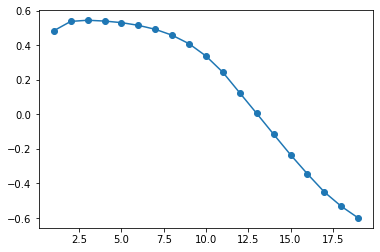

In [68]:
plt.scatter(th_list, my_acc)
plt.plot(th_list, my_acc)
plt.show()

In [ ]:
# Choosing best threshold
losses = []

xmin = min(groundtruth['x']); xmax = max(groundtruth['x'])
ymin = min(groundtruth['y']); ymax = max(groundtruth['y'])

t0 = time.time()
for th in threshold_list:
    point_cc = []
    gt_cc = []
    for now_x in np.arange(xmin, xmax+xinc, xinc):
        for now_y in np.arange(ymin, ymax+yinc, yinc):

            my_point = my_block[ (my_block['x'] >= now_x) & (my_block['x'] < now_x+xinc) 
                           & (my_block['y'] >= now_y) & (my_block['y'] < now_y+yinc)]
    
            point_cc.append(CC_manual_percentage_app3(my_point, outliers, vegetation))
            aux = groundtruth[ (groundtruth['x'] == now_x) & (groundtruth['y'] == now_y) ][['CC']].iloc[0][0]
            if aux > 100:
                aux = 100
            gt_cc.append( aux ) 
    
    losses.append(r2_score(gt_cc, point_cc))
    
print("Execution time with", len(threshold_list),"iterations:", time.time()-t0)

In [ ]:
plt.subplots(figsize=(15, 10))

plt.scatter(gt_cc, point_cc)
plt.xlabel('groundtruth CC')
plt.ylabel('predicted CC')
plt.plot([0,100],[0,100], color='red')
plt.show()

In [ ]:
plt.subplots(figsize=(15, 10))

plt.scatter(threshold_list, losses)
plt.plot(threshold_list, losses)

plt.xlabel('Threshold List')
plt.ylabel('Rsq')
plt.show()